In [1]:
from itertools import accumulate

from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import cross_entropy
from torch import Tensor

plt.rcParams['figure.dpi'] = 250
%config InlineBackend.figure_format = 'retina'

In [2]:
x, y = load_digits(return_X_y=True)

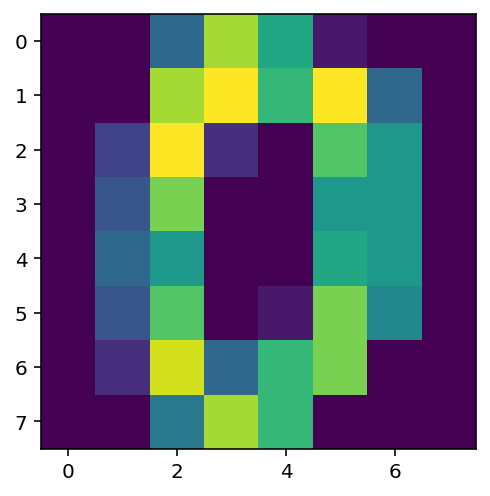

In [3]:
plt.imshow(x[0].reshape(8, 8));

In [4]:
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)

In [5]:
def initialize_model() -> torch.nn.Module:
    return torch.nn.Sequential(
        torch.nn.Linear(64, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 10),
    )

In [6]:
# Create a sequence of tasks from the digits dataset.
tasks: list[tuple[torch.Tensor, torch.Tensor]] = []

# Task 1 are digits 0 and 1.
tasks.append((x[y <= 1], y[y <= 1]))

# Task 2 are digits 2 to 5.
tasks.append((x[(y >= 2) & (y <= 5)], y[(y >= 2) & (y <= 5)]))

# Task 3 are the remaining digits except 9.
tasks.append((x[(y >= 6) & (y < 9)], y[(y >= 6) & (y < 9)]))

# Task 4 is digit 9.
tasks.append((x[y == 9], y[y == 9]))

In [7]:
tasks[0][0].shape, tasks[1][0].shape

(torch.Size([360, 64]), torch.Size([723, 64]))

In [8]:
def deep_clone_model(old_model: torch.nn.Module) -> torch.nn.Module:
    model = initialize_model()
    model.load_state_dict(old_model.state_dict())
    for param in model.parameters():
        param.data = param.data.clone().detach()
    return model

In [9]:
num_epochs = 50
lr = 0.01


def compute_acc(model: torch.nn.Module, x: Tensor, y: Tensor) -> float:
    acc = (model(x).argmax(dim=1) == y).float().mean()
    return acc.item()


def train_on_task(old_model: torch.nn.Module, x: Tensor, y: Tensor) -> torch.nn.Module:
    # Each task is trained on a new (copied) set of weights.
    model = deep_clone_model(old_model)

    # Recreate the optimizer for each task.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for _ in range(num_epochs):
        optimizer.zero_grad()
        loss = cross_entropy(model(x), y)
        loss.backward()
        optimizer.step()

    return model

In [10]:
rand_model = initialize_model()

task_1_model = train_on_task(rand_model, *tasks[0])
task_2_model = train_on_task(task_1_model, *tasks[1])

# Compute accuracy matrix
models = [rand_model, task_1_model, task_2_model]
acc_mat = torch.zeros((len(models), len(tasks)))

for i, model in enumerate(models):
    for j, task in enumerate(tasks):
        acc_mat[i, j] = compute_acc(model, *task)

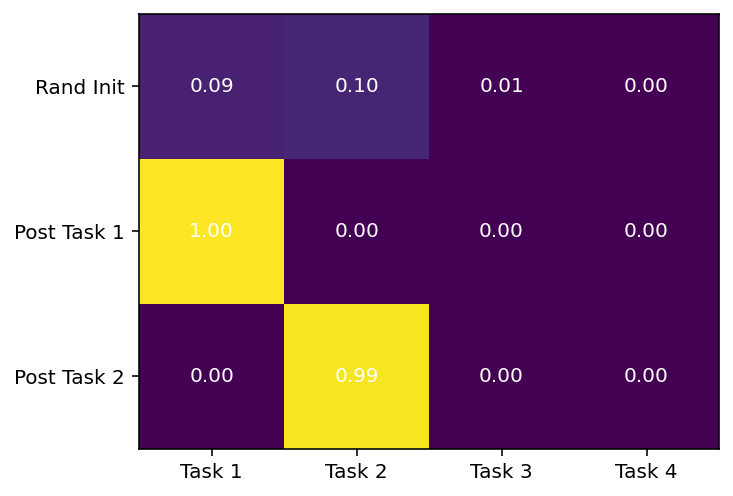

In [11]:
# Plot the acc mat and show the values in the cells.
plt.imshow(acc_mat);
for i in range(len(models)):
    for j in range(len(tasks)):
        plt.text(j, i, f"{acc_mat[i, j]:.2f}", ha="center", va="center", color="w")

plt.xticks(range(len(tasks)), [f"Task {i}" for i in range(1, len(tasks) + 1)])
plt.yticks(range(len(models)), ["Rand Init"] + [f"Post Task {i}" for i in range(1, len(models))]);

In [12]:
# Algorithm 1: Train a GEM over an ordered continuum of data.


def get_task_grad_vec(model: torch.nn.Module, x: Tensor, y: Tensor) -> Tensor:
    mean_loss = cross_entropy(model(x), y).mean()
    grads = torch.autograd.grad(mean_loss, model.parameters())
    return torch.concat([g.flatten() for g in grads])


def get_lagrange_multiplier(G: Tensor, g: Tensor) -> Tensor:
    # Solves Eq. (11).
    # GG^T is TxT (T = |tasks|)
    # min_v (1/2v^T GG^T v + g^T G^T v), s.t. v >= 0
    num_epochs = 1000
    lr = 0.01

    GG = G @ G.T
    Gg = G @ g

    v = torch.rand(G.shape[0], requires_grad=True)

    # v = torch.ones(G.shape[0], requires_grad=True)
    optimizer = torch.optim.Adam([v], lr=lr)

    eps = 10e-2
    v = v * eps

    for _ in range(num_epochs):
        optimizer.zero_grad()
        v.grad = GG @ v + Gg @ v
        optimizer.step()
        v = v.clip(min=0)  # Project onto the non-negative orthant.

    return v


def project_grad(G: Tensor, g: Tensor) -> list[Tensor]:
    v_star = get_lagrange_multiplier(G, g)
    g_tilde = G.T @ v_star + g
    return g_tilde


def gem_grad_update_(
    model: torch.nn.Module, task_memory: list[tuple[Tensor, Tensor]]
) -> None:
    """Updates the gradients of model in-place using GEM."""
    if not task_memory:
        return

    # Assumes model.parameters() returns params in a stable order.
    g = torch.concat([p.grad.flatten() for p in model.parameters()])
    G = torch.stack([get_task_grad_vec(model, x, y) for x, y in task_memory])

    if torch.all(G @ g > 0):
        return

    g_tilde = project_grad(G, g)

    print(f"{G @ g_tilde=}")

    # Slice the single column large proejcted grad into the parts for each param.
    g_sizes = [p.numel() for p in model.parameters()]
    g_offsets = [0] + list(accumulate(g_sizes))

    # In-place update of the gradients.
    for i, p in enumerate(model.parameters()):
        g_tilde_for_p = g_tilde[g_offsets[i] : g_offsets[i + 1]]
        print(f"{torch.norm(p.grad.flatten() - g_tilde_for_p)=}")
        p.grad = g_tilde_for_p.reshape(p.grad.shape)


def sample_from_task(x: Tensor, y: Tensor, ratio: float = 1.0) -> tuple[Tensor, Tensor]:
    """Samples ratio examples from the task."""
    num_samples = int(len(x) * ratio)
    idx = torch.randperm(len(x))[:num_samples]
    return x[idx], y[idx]


def train_with_gem(
    initial_model: torch.nn.Module, tasks: list[tuple[Tensor, Tensor]]
) -> list[torch.nn.Module]:
    num_epochs = 50
    lr = 0.01

    # M_t <- {sample of examples} for all tasks
    task_memory = []

    models = [initial_model]
    for task_idx, (x, y) in enumerate(tasks):
        print(f"Learning task {task_idx}")
        if task_idx > 0:
            task_memory.append(sample_from_task(*tasks[task_idx - 1]))

        # Each task is trained on a new (copied) set of weights.
        model = deep_clone_model(models[-1])
        # Recreate the optimizer for each task.
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        for _ in range(num_epochs):
            optimizer.zero_grad()
            loss = torch.nn.functional.cross_entropy(model(x), y)
            loss.backward()
            gem_grad_update_(model, task_memory)
            optimizer.step()

        models.append(model)
    return models

In [13]:
models = train_with_gem(initialize_model(), tasks)

Learning task 0
Learning task 1
G @ g_tilde=tensor([-3.7478e-05], grad_fn=<MvBackward0>)
torch.norm(p.grad.flatten() - g_tilde_for_p)=tensor(1.6792e-09, grad_fn=<LinalgVectorNormBackward0>)
torch.norm(p.grad.flatten() - g_tilde_for_p)=tensor(0., grad_fn=<LinalgVectorNormBackward0>)
torch.norm(p.grad.flatten() - g_tilde_for_p)=tensor(7.3857e-10, grad_fn=<LinalgVectorNormBackward0>)
torch.norm(p.grad.flatten() - g_tilde_for_p)=tensor(2.9104e-11, grad_fn=<LinalgVectorNormBackward0>)
torch.norm(p.grad.flatten() - g_tilde_for_p)=tensor(1.0668e-16, grad_fn=<LinalgVectorNormBackward0>)
torch.norm(p.grad.flatten() - g_tilde_for_p)=tensor(0., grad_fn=<LinalgVectorNormBackward0>)
G @ g_tilde=tensor([-11.9829], grad_fn=<MvBackward0>)
torch.norm(p.grad.flatten() - g_tilde_for_p)=tensor(0.0125, grad_fn=<LinalgVectorNormBackward0>)
torch.norm(p.grad.flatten() - g_tilde_for_p)=tensor(0.0002, grad_fn=<LinalgVectorNormBackward0>)
torch.norm(p.grad.flatten() - g_tilde_for_p)=tensor(0.0108, grad_fn=<Lina

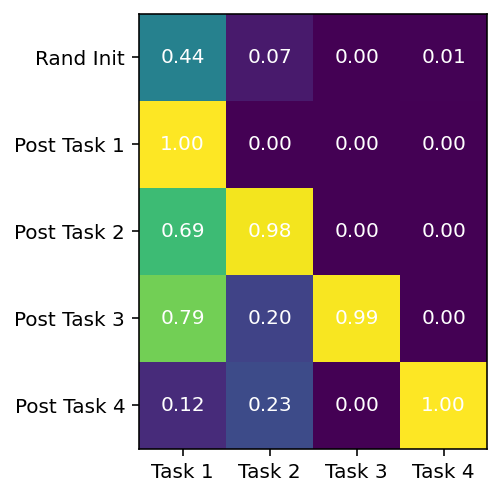

In [14]:
acc_mat = torch.zeros((len(models), len(tasks)))

for i, model in enumerate(models):
    for j, task in enumerate(tasks):
        acc_mat[i, j] = compute_acc(model, *task)

# Plot the acc mat and show the values in the cells.
plt.imshow(acc_mat);
for i in range(len(models)):
    for j in range(len(tasks)):
        plt.text(j, i, f"{acc_mat[i, j]:.2f}", ha="center", va="center", color="w")

plt.xticks(range(len(tasks)), [f"Task {i}" for i in range(1, len(tasks) + 1)])
plt.yticks(range(len(models)), ["Rand Init"] + [f"Post Task {i}" for i in range(1, len(models))]);